# Introduction to deep reinforcement learning for SDP optimization

In this notebook we tackle the problem of finding the best approximation to the ground state energy of a many-body system under the action of the hamiltonian $H$. More precisely, we aim to find the optimal set of compatibility constraints, under a limited computational budget, used to find the ground state energy through SDP. 

The optimal divison is the one that best approximates the system's energy $E$. Nonetheless, there is a tradeoff between such accuracy and the complexity of the representation in terms of parameters: larger constraints will provide better energy approximations at the cost of higher computational requirements. 

In [ ]:
from bounce.environment import SDPEnvironment
from bounce.agents import DQNAgent, DQN
from bounce.hamiltonian import XXHamiltonian
from bounce.budget_profiles import FlatProfile
from bounce.training import train_agent, DQNTrainer
from bounce.utils import plot_trainings

import numpy as np
from matplotlib import pyplot as plt
from nbdev.showdoc import show_doc

%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Step-by-step procedure

### Environment

With the network architecture, we now proceed to define the environment under whose conditions the algorithm will perform the optimisation. Basically, the environment sets the rules of the game: it contains the information of the problem to be solved and provides the state-transitions and rewards. 

In [ ]:
N = 6  # number of sites

#### Hamiltonian

In the current release, we only support 1D hamiltonians, such as the XX or XY Heisenberg models. You can build your own Hamiltonians pretty easily.  

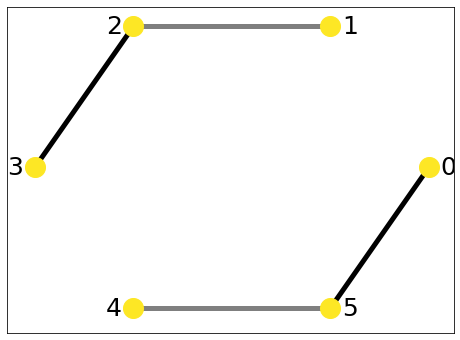

In [ ]:
B0, J0 = [1]*N, [i%3 for i in range(N)]
H = XXHamiltonian(N, np.array(B0), np.array(J0))
H.draw_system()

#### Computational budget

Let us define what will be the compuational budget within which the optimization is carried out. We define it in terms of the amount of free parameters that the SDP accounts for. 

In [ ]:
max_limit = 300
profile = FlatProfile(max_limit)

profile.plot_profile()

Flat limit of 300


#### Environment

Finally, create the environment with the given Hamiltonian and computational budget. There can also be specified the reward criterion but we have found that `SDPEnvironment.energy_norm_reward` consistently provides the best results.

In [ ]:
env = SDPEnvironment(N, H, profile, reward_criterion="energy_norm")

The environment is always initialised to the simplest possible set of constraints, that is, an empty state corresponding to 1-body constraints. The method `show_constraints` returns a visualization of the active constraints with boolean indicators. In order to see what are the current active constraints in an explicit way, we can get the `layout`, which lists them in the form of `np.arrays`.

In [ ]:
env.show_constraints()
env.layout

2: 0 0 0 0 0 0
3: 0 0 0 0 0 0
4: 0 0 0 0 0 0


[array([0]), array([1]), array([2]), array([3]), array([4]), array([5])]

We can directly modify the state (it's a `np.array`) or use the functionalities within the environment.

In [ ]:
env.state[N] = 1
env.show_constraints()
env.layout

2: 0 0 0 0 0 0
3: 1 0 0 0 0 0
4: 0 0 0 0 0 0


[array([0, 1, 2]), array([3]), array([4]), array([5])]

We can reset the environment any time with `env.reset()`.

In [ ]:
env.reset()
env.show_constraints()

2: 0 0 0 0 0 0
3: 0 0 0 0 0 0
4: 0 0 0 0 0 0


The best practice to edit the state is by performing a step. Notice below that some of the 2-body constraints are added along the 3-body one. This is because those two are contained within the larger one and, therefore, do not alter the result (the layout is the same).  

In [ ]:
env.explorative_step(N, 0)
env.show_constraints()
env.layout

2: 1 1 0 0 0 0
3: 1 0 0 0 0 0
4: 0 0 0 0 0 0


[array([0, 1, 2]), array([3]), array([4]), array([5])]

In [ ]:
env.reset();

### Agent

With the environment set, let us proceed to define the agent that will perform the optimization. 

#### Neural network architecture
Let us define, first, the neural network architecture that will encode the Q-values in our reinforcement learning algorithm. By default, when calling `train_from_scracth`, the `DQNAgent` implements the predefined `DQN` model. Nonetheless, different architectures can be passed on.  

In [ ]:
class Net(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 3*state_size)
        self.fc2 = nn.Linear(3*state_size, 2*action_size)
        self.fc3 = nn.Linear(2*action_size, 2*action_size)
        self.fc4 = nn.Linear(2*action_size, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#### Agent

With the network architecture, we can proceed to create the network and the agent. 

In [ ]:
show_doc(DQNAgent)

<h2 id="DQNAgent" class="doc_header"><code>class</code> <code>DQNAgent</code><a href="https://github.com/BorjaRequena/bounce/tree/master/bounce/agents.py#L18" class="source_link" style="float:right">[source]</a></h2>

> <code>DQNAgent</code>(**`N`**, **`model`**, **`learning_rate`**=*`0.001`*, **`criterion`**=*`None`*, **`optimizer`**=*`None`*, **`batch_size`**=*`120`*, **`target_update`**=*`5`*, **`gamma`**=*`0.85`*, **`eps_0`**=*`1`*, **`eps_decay`**=*`0.999`*, **`eps_min`**=*`0.1`*)



In [ ]:
# Agent parameters
learning_rate = 1e-3
batch_size = 150
target_update = 5
eps_0 = 1.
eps_decay = 0.995
eps_min = 0.1
gamma = 0.85

In [ ]:
net = Net(state_size = len(env.state), action_size = len(env.state)+1)
criterion = nn.SmoothL1Loss(reduction = 'sum')
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

agent = DQNAgent(N = env.N,
                 model = net, 
                 learning_rate = learning_rate,
                 criterion = criterion,        
                 optimizer = optimizer, 
                 batch_size = batch_size,
                 target_update = target_update,
                 eps_0 = eps_0, 
                 eps_decay = eps_decay,
                 eps_min = eps_min,
                 gamma = gamma)

### Learning

We are now ready to train our agent!

The algorithm will perform trajectories of length `time_steps` for a certain amount of `episodes`. We will rely on `train_agent`.

In [ ]:
show_doc(train_agent)

<h4 id="train_agent" class="doc_header"><code>train_agent</code><a href="https://github.com/BorjaRequena/bounce/tree/master/bounce/training.py#L108" class="source_link" style="float:right">[source]</a></h4>

> <code>train_agent</code>(**`env`**, **`agent`**, **`episodes`**, **`time_steps`**=*`20`*, **`opt`**=*`None`*, **`best_ref`**=*`None`*, **`evaluate`**=*`True`*, **`train_id`**=*`None`*, **`ckp`**=*`100`*, **`save`**=*`True`*, **`break_opt`**=*`False`*)

Trains an agent given an environment.

In [ ]:
# Learning parameters
episodes = 500
time_steps = 15

In [ ]:
results = train_agent(env, agent, episodes, time_steps=time_steps)

In order to plot the results, we can call `plot_trainings`, which always takes the training results dictionary. Hence, we have to extract the trianing results with `results['training']` and build the appropriate dictionary. This is just to illustrate the procedure but, instead, we will always be using the trainers, which already provide the right format for fast and easy plotting.    

In [ ]:
trained_agent, explored_env, rewards, params, energies, _, _ = results['training']
training_results = {'rewards': [rewards], 'params': [params], 'energies': [energies]}

<Figure size 720x2880 with 0 Axes>

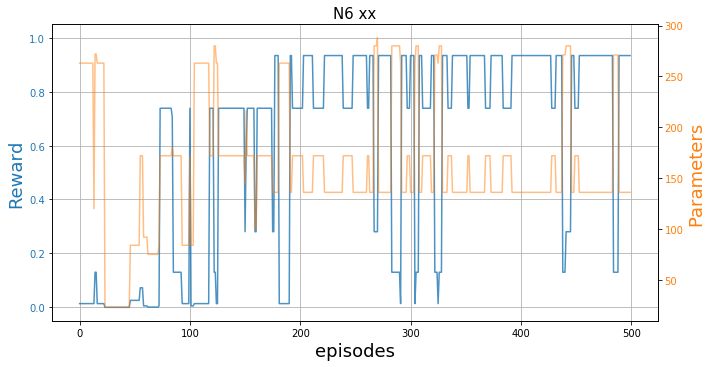

In [ ]:
plt.figure(figsize=(10,40))
plot_trainings(training_results, eval_optims=False)
plt.title(f"N{N} {H.model}", fontsize=15);

Furthermore, we can see what is the last state in the evaluation episode. 

In [ ]:
env.show_constraints()
env.layout

2: 0 1 1 0 1 1
3: 0 1 0 0 1 0
4: 0 0 0 0 0 0


[array([1, 2, 3]), array([0, 4, 5])]

And compare it with the best set of constriants the agent has encountered along the way.

In [ ]:
env.best_layout

[array([1, 2, 3]), array([0, 4, 5])]

We can see that the agent has, indeed, found the optimal set of constriants and has successfully converged.

## Trainer 

The full step-by-step procedure previously introduced is fully captured by the `Trainer` classes. More precisely, the `DQNTrainer` is the one devoted for this task. 

In [ ]:
show_doc(DQNTrainer)

<h2 id="DQNTrainer" class="doc_header"><code>class</code> <code>DQNTrainer</code><a href="https://github.com/BorjaRequena/bounce/tree/master/bounce/training.py#L24" class="source_link" style="float:right">[source]</a></h2>

> <code>DQNTrainer</code>(**`N`**, **`H`**, **`budget_profile`**, **`reward_fun`**=*`'energy_norm'`*, **`n_agents`**=*`1`*, **`models`**=*`None`*, **`arch`**=*`DQN`*, **`n_jobs`**=*`1`*, **`learning_rate`**=*`0.001`*, **`criterion`**=*`None`*, **`optimizer`**=*`None`*, **`batch_size`**=*`120`*, **`target_update`**=*`5`*, **`gamma`**=*`0.85`*, **`eps_0`**=*`1`*, **`eps_decay`**=*`0.999`*, **`eps_min`**=*`0.1`*)

Trainer for DQN agents

The environment details: `N`, `H` and the budget profile must be provided to fully define the problem. Declaring the trainer, we can specify the properties of the `DQNAgent`. 

The agent network is created, by default, instantiating a `DQN` architecture, specified by `arch`. There are two ways to specify the agent's network model: we can either introduce an architecutre `arch` that will be initalized by the trainer, or provide a list of pre-trained `models` from which the agents will be created. 

In [ ]:
# Environment parameters
N = 6 
B, J = [1]*N, [i%3 for i in range(N)]
H = XXHamiltonian(N, np.array(B), np.array(J))
max_limit = 300
profile = FlatProfile(max_limit)

# Agent parameters
batch_size = 150
eps_decay = 0.992

# Training parameters
episodes = 500
time_steps = 7
opt = (-10.9443, 127) # True optimal for reference (energy, parameters) explained further below

In [ ]:
dqn = DQNTrainer(N, H, profile, batch_size=batch_size, eps_decay=eps_decay)

In [ ]:
results = dqn.train(episodes=episodes, time_steps=time_steps, opt=opt)

<Figure size 720x2880 with 0 Axes>

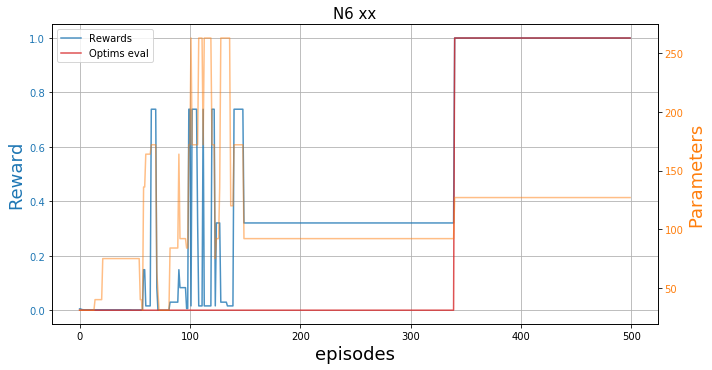

In [ ]:
plt.figure(figsize=(10,40))
plot_trainings(results["training"], eval_optims=True)
plt.title(f"N{N} {H.model}",fontsize=15);

Knowing the optimal set of constraints beforehand, we can see that the agent has converged to the optimal solution by the end of the training. We can also plot the number of times that the optimal configuration has been seen during the exploration period by setting `expl_optims=True` in `plot_trainings`.

## Optimal state references

For different Hamiltonians with varying number of sites and budgets, the optimal layouts may change. We define the optimal layout in terms of the energy and the parameters together. 

In many cases, the maximum possible energy is achieved within the parameter limit and, therefore, there may be configurations that provide the same energy but at a larger computational cost. This quantity is captured in `environment.best`, which provides the best energy obtained by the agent together with the minimum and maximum computational cost with which the energy can be obtained.  

The optimal state references can be passed to `train_agent` with the argument `opt` in order to keep track of the visited optimal states in both during exploration and evaluation. 

### Inhomogeneous Hamiltonian
Here we provide a list of optimal references (given a budget) for the XX Heisenberg model with parameters `B, J = [1]*N, [i%3 for i in range(N)]`. This is the Hamiltonian used for the benchmarking of the different optimization algorithms in the paper (see example `03_benchmarking.ipynb`).

Cutting constraints to 51 (groups of 4)


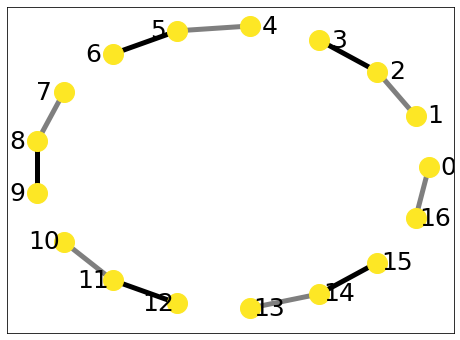

In [ ]:
N = 17
B, J = np.array([1]*N), np.array([i%3 for i in range(N)])
H = XXHamiltonian(N, B, J)
H.draw_system()

env = SDPEnvironment(N, H, FlatProfile(1000))

In [ ]:
# N = 5, budget = 245
opt = (-7.47214, 79)
best_ref = np.array([*opt, 240])

# N = 6, budget = 300
opt = (-10.94427, 127)
best_ref = np.array([*opt, 288])

# N = 7, budget = 340
opt = (-11.9427, 131)
best_ref = np.array([*opt, 336])

# N = 8, budget = 385
opt = (-12.94427, 143)
best_ref = np.array([*opt, 385])

# N = 9, budget = 435
opt = (-16.41641, 191)
best_ref = np.array([*opt, 432])

# N = 10, budget = 485
opt = (-17.41641, 195)
best_ref = np.array([*opt, 480])

# N = 11, budget = 530
opt = (-18.41641, 207)
best_ref = np.array([*opt, 528])

# N = 12, budget = 576
opt = (-21.88854, 255)
best_ref = np.array([*opt, 576])

# N = 13, budget = 625
opt = (-22.88854, 259)
best_ref = np.array([*opt, 624])

# N = 14, budget = 675
opt = (-23.8854, 271)
best_ref = np.array([*opt, 672])

# N = 15, budget = 725
opt = (-27.36068, 319)
best_ref = np.array([*opt, 720])

# N = 16, budget = 770
opt = (-28.36068, 323)
best_ref = np.array([*opt, 768])

# N = 17, budget = 820
opt = (-29.36068, 335)
best_ref = np.array([*opt, 816])